In [ ]:
!pip install timm
!pip install matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 38.6 MB/s eta 0:00:00


In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Navigate to the dataset folder in Google Drive
dataset_path = '/content/drive/MyDrive/Datasets/kvasir-dataset-v2/'

In [ ]:
# Step 3: Data Preprocessing
# Preprocessing and Data Augmentation for training and validation
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Step 4: Load Kvasir v2 dataset using ImageFolder
# (assumes all images are organized in subfolders representing classes)
train_dataset = datasets.ImageFolder(root=dataset_path, transform=transform_train)
val_dataset = datasets.ImageFolder(root=dataset_path, transform=transform_val)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
# Step 5: Define the Vision Transformer (ViT) Model
# Use timm to load the pretrained ViT model
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=len(train_dataset.classes))

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [ ]:
# Step 6: Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Step 7: Train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/total:.4f}, Accuracy: {100 * correct/total:.2f}%')

        # Validation after each epoch
        validate_model(model, val_loader, criterion)

def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Validation Loss: {val_loss/total:.4f}, Accuracy: {100 * correct/total:.2f}%')

# Step 8: Start training
num_epochs = 10
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

# Save the model after training
torch.save(model.state_dict(), '/content/drive/MyDrive/kvasir_v2_vit_model.pth')

In [ ]:
# Step 1: Load the saved model
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=len(train_dataset.classes))
model.load_state_dict(torch.load('/content/drive/MyDrive/kvasir_v2_vit_model.pth',map_location=torch.device('cpu')))

# Move model to GPU if available
#model.to(device)

<ipython-input-16-dbb0affc039b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/kvasir_v2_vit_model.pth',map_locati

<All keys matched successfully>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Function to test a single image and display it
def predict_image(image_path, model):
    model.eval()

    # Preprocess the image (resize, normalize, etc.)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Open the image
    img = Image.open(image_path).convert('RGB')

    # Apply transformations
    input_img = transform(img).unsqueeze(0)  # Add batch dimension

    # Move to device
    input_img = input_img.to(device)

    # Perform inference
    with torch.no_grad():
        output = model(input_img)
        _, predicted = torch.max(output, 1)

    class_names = train_dataset.classes  # List of class names
    predicted_class = class_names[predicted.item()]

    # Print the predicted class
    print(f'Predicted class: {predicted_class}')

    # Display the image
    plt.imshow(np.array(img))
    plt.title(f'Predicted: {predicted_class}')
    plt.axis('off')  # Remove axis
    plt.show()

    return predicted_class

Predicted class: ulcerative-colitis


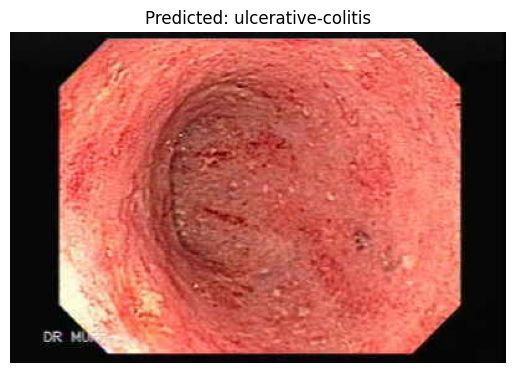

'ulcerative-colitis'

In [ ]:
# Test on a new image
image_path = '/content/drive/MyDrive/Datasets/Samples/sample1.jpg'  # Replace with your image path
predict_image(image_path, model)

Predicted class: normal-z-line


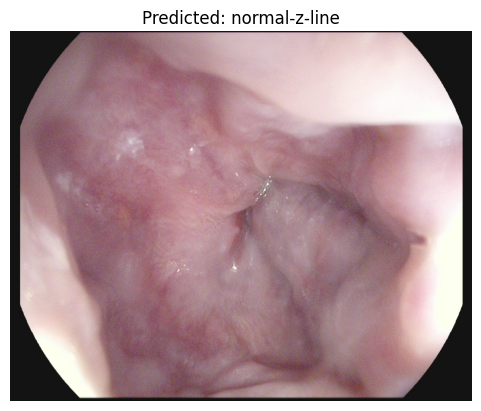

'normal-z-line'

In [ ]:
# Test on a new image
image_path = '/content/drive/MyDrive/Datasets/Samples/sample2.jpg'  # Replace with your image path
predict_image(image_path, model)